<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/%5B261663%5DQ5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IA353 - Redes Neurais
# EFC3 - Questão 5_1

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  Samuel Borges Ferreira Gomes 

### 5.1. Imports

In [1]:
!pip install keras

In [2]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

from keras.regularizers import l1
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, Input, Conv2DTranspose, Conv2D, Reshape
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical

### 5.2. Reading the data

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


In [6]:
x_images = x_train.reshape(x_train.shape[0], 28, 28)

In [7]:
# Definition of a function to visualize some digits
def show(img):
    plt.imshow(img, cmap = "gray", interpolation = "none")

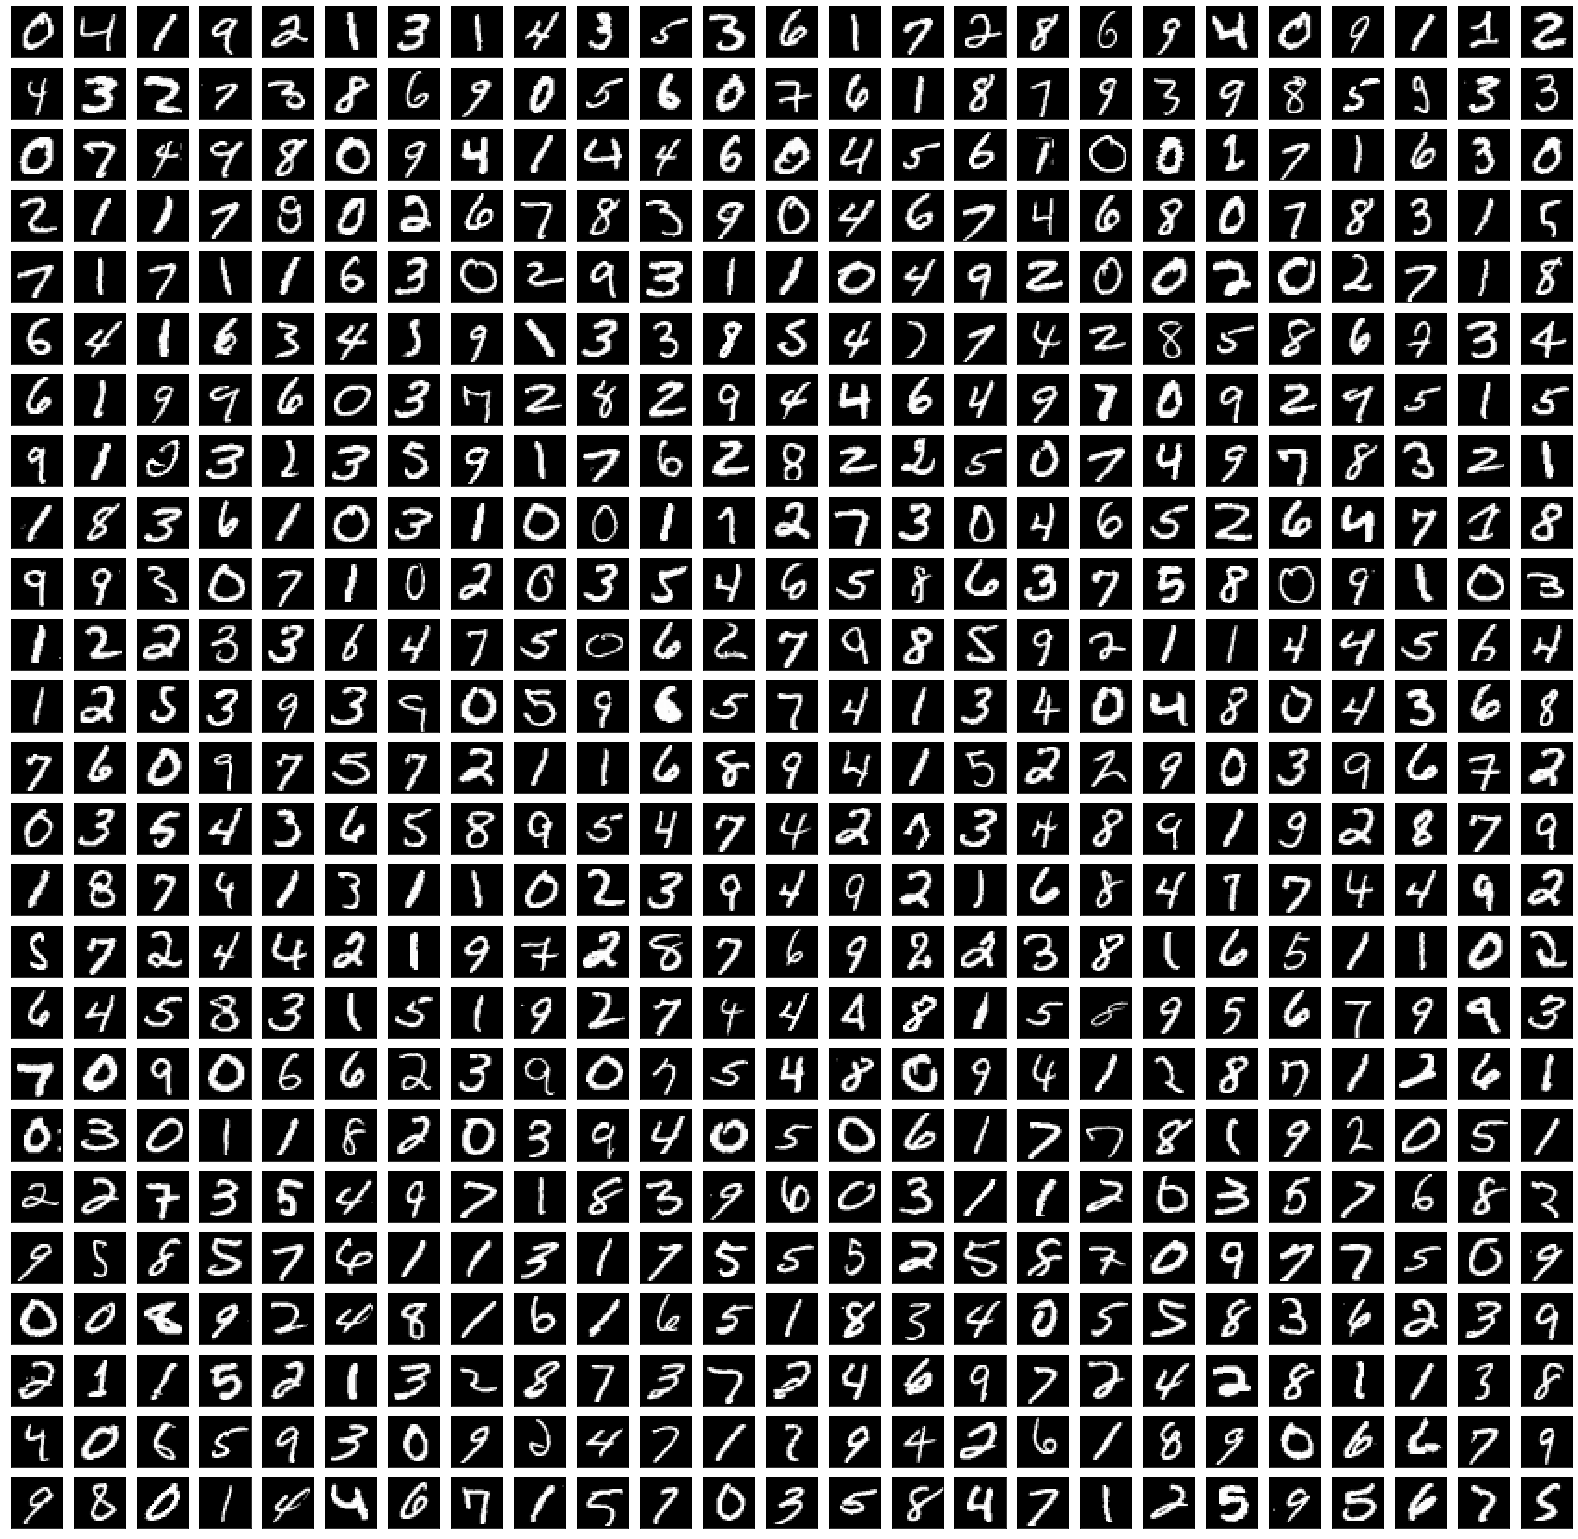

In [8]:
# Visualization of 25 x 25 original images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(x_images[ind])
        plt.xticks([])
        plt.yticks([])
        ind+=1

### 5.3 Proposal for the autoencoder architecture

In [9]:
input = Input(shape=(28,28,1))

# Encoder
encoder = Conv2D(filters=32, strides=2, kernel_size=2, activation='relu')(input)
encoder = Conv2D(filters=64, strides=2, kernel_size=2, activation='relu')(encoder)
encoder = Conv2D(filters=128, strides=2, kernel_size=2, activation='relu')(encoder)
encoder = Flatten()(encoder)

encoder = Dense(2, name='bottleneck')(encoder) # Linear activation function at the bottleneck


# Decoder
decoder = Dense(3*3*128, activation='relu')(encoder)
decoder = Reshape((3,3,128))(decoder)
decoder = Conv2DTranspose(filters=64, strides=2, kernel_size=3, activation="relu")(decoder)
decoder = Conv2DTranspose(filters=32, strides=2, kernel_size=2, activation="relu")(decoder)
decoder = Conv2DTranspose(filters=1, strides=2, kernel_size=2, activation="sigmoid")(decoder)

# Autoencoder
autoencoder = Model(input, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         32896     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 2306      
_________________________________________________________________
dense (Dense)                (None, 1152)              3456  

In [10]:
autoencoder.compile(optimizer = "adam", loss = "msle")
X = x_train.reshape(x_train.shape[0], 28, 28)
history = autoencoder.fit(X, X, batch_size = 128, epochs = 50, validation_data=(x_test, x_test), verbose = 1)

Epoch 1/50
469/469 [==============================] - 19s 7ms/step - loss: 0.0659 - val_loss: 0.0289
Epoch 2/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0284 - val_loss: 0.0259
Epoch 3/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0254 - val_loss: 0.0243
Epoch 4/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0241 - val_loss: 0.0236
Epoch 5/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0234 - val_loss: 0.0227
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0228 - val_loss: 0.0224
Epoch 7/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0224 - val_loss: 0.0220
Epoch 8/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0221 - val_loss: 0.0218
Epoch 9/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0218 - val_loss: 0.0216
Epoch 10/50
469/469 [==============================] - 2s 5ms/step - loss: 0.0216 - val_loss: 0.021

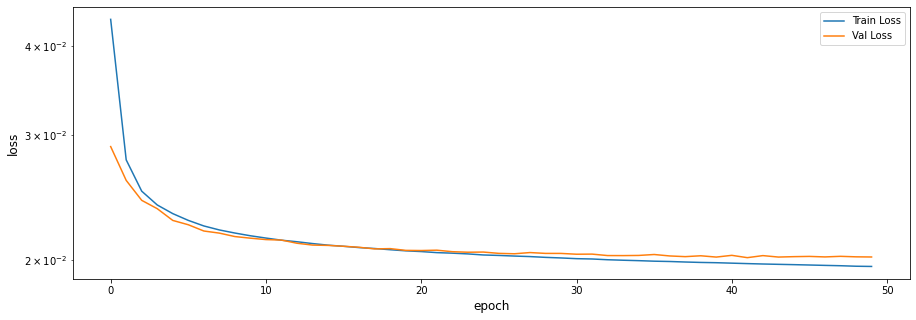

In [40]:
from matplotlib.pyplot import figure
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_dff = pd.DataFrame.from_dict({'val_loss':history.history['val_loss']})
# plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
# plot_dff.plot(logy=True, figsize=(15,5), fontsize=12)
figure(figsize=(15, 5))
plt.plot(plot_df)
plt.plot(plot_dff)
plt.yscale('log')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(('Train Loss','Val Loss'))
plt.show()

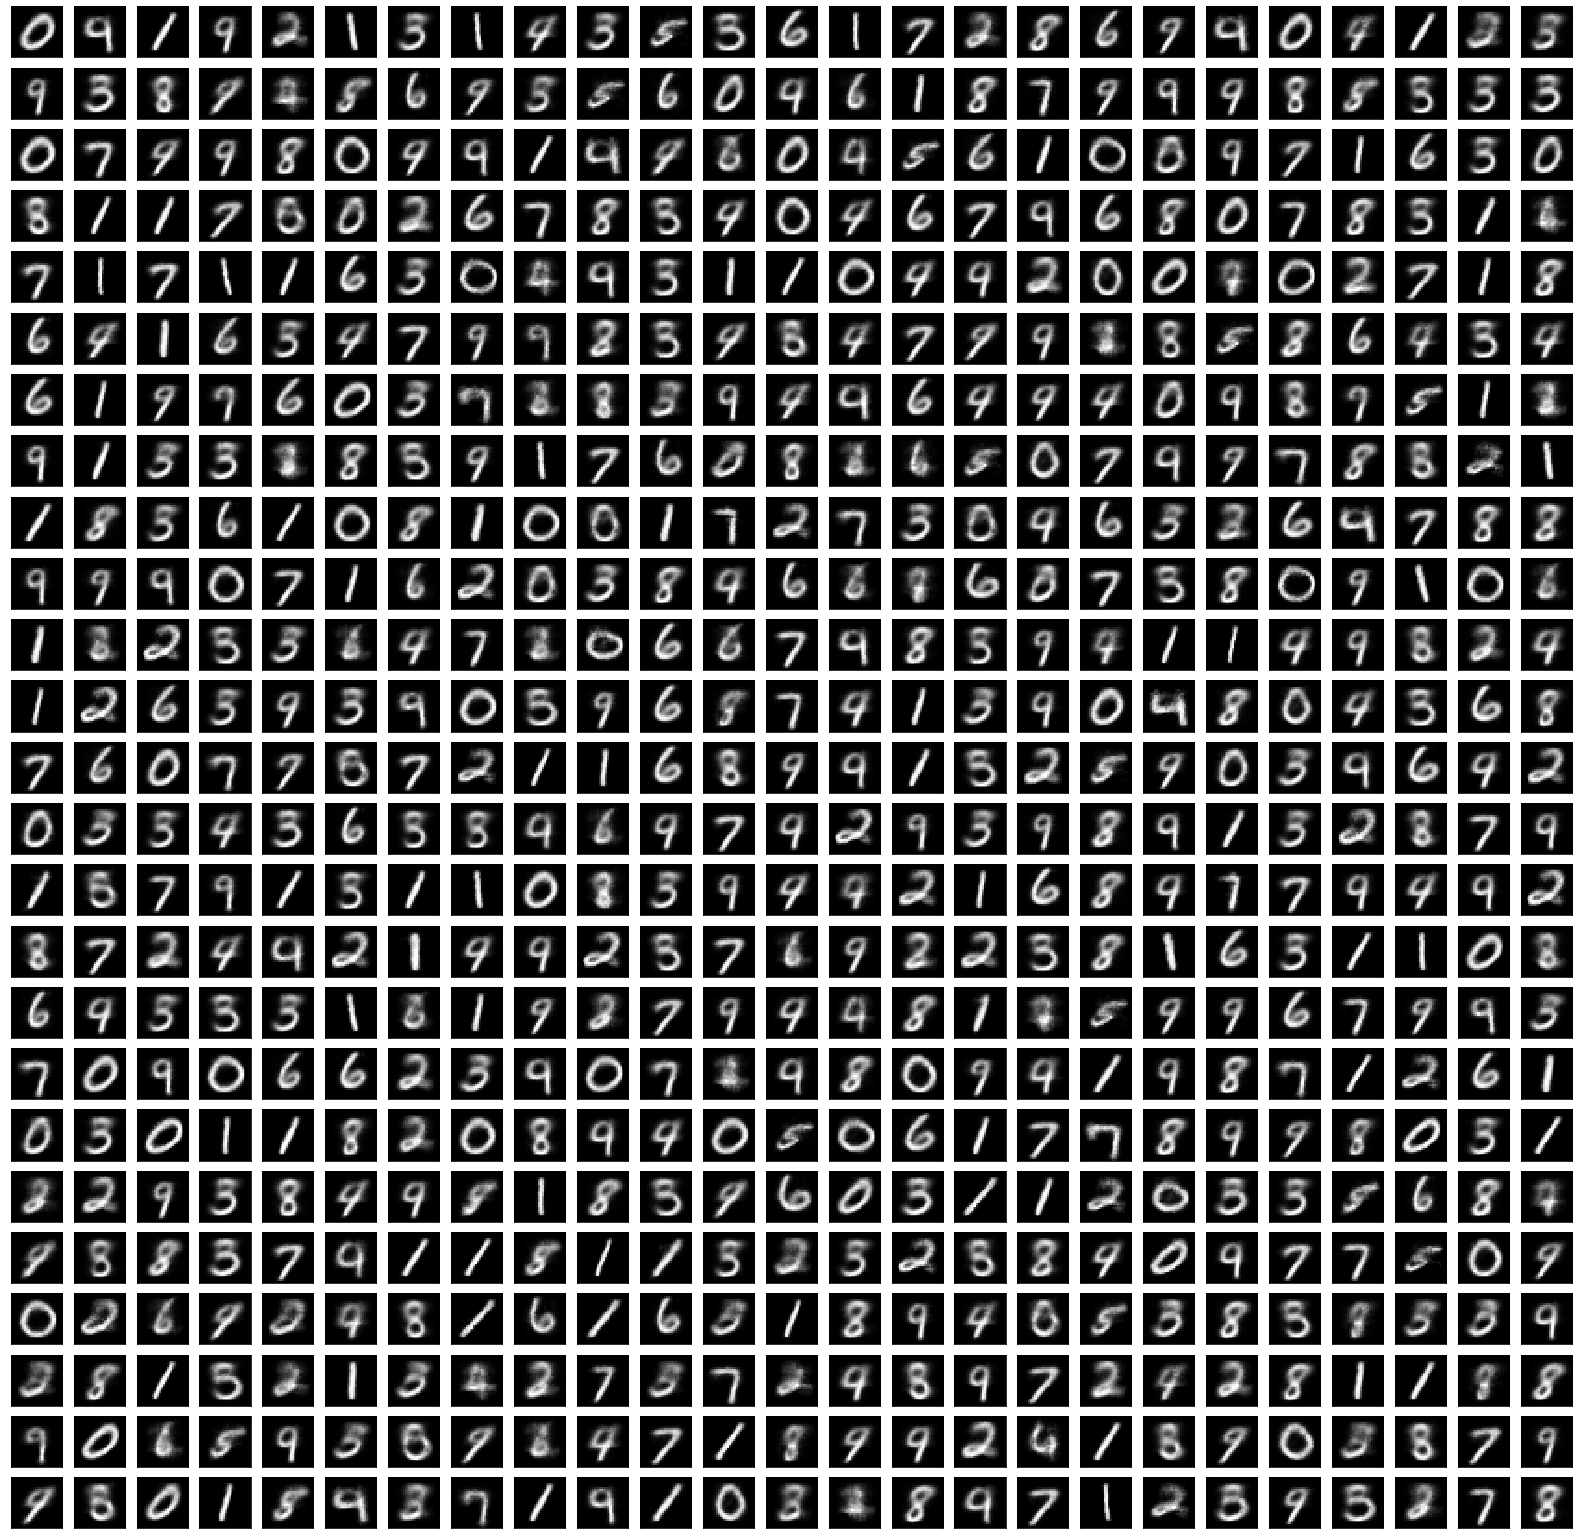

In [12]:
|# Visualization of 25 x 25 reconstructed images of digits
fig = plt.figure(figsize=(28,28))
ind = 1
for i in range(1, 26, 1):
    for j in range(1, 26, 1):
        fig.add_subplot(25,25,ind)
        show(autoencoder.predict(np.expand_dims(x_images[ind], 0)).reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
        ind+=1

In [13]:
encoded = Model(input, autoencoder.get_layer(name='bottleneck').output)

# Bulding decoder
encoded_input = Input(shape=(2,))
encoded_layer_1 = autoencoder.layers[-5]
encoded_layer_2 = autoencoder.layers[-4]
encoded_layer_3 = autoencoder.layers[-3]
encoded_layer_4 = autoencoder.layers[-2]
encoded_layer_5 = autoencoder.layers[-1]

decoded = encoded_layer_1(encoded_input)
decoded = encoded_layer_2(decoded)
decoded = encoded_layer_3(decoded)
decoded = encoded_layer_4(decoded)
decoded = encoded_layer_5(decoded)

decoded = Model(encoded_input, decoded)

### 5.4 Visualizing the mapping of the labeled images in the manifold

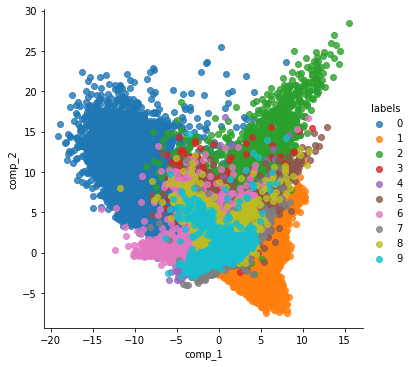

In [14]:
import seaborn as sns

x_flat = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])

x_proj = encoded.predict(x_flat[:60000])
x_proj.shape

proj = pd.DataFrame(x_proj)
proj.columns = ["comp_1", "comp_2"]
proj["labels"] = y_train[:60000]
sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)

### 5.5. Generating new digits by moving along the manifold (latent 2D space)
**Please, adjust the scale whenever necessary.**

### 5.5.1 Moving along a circle

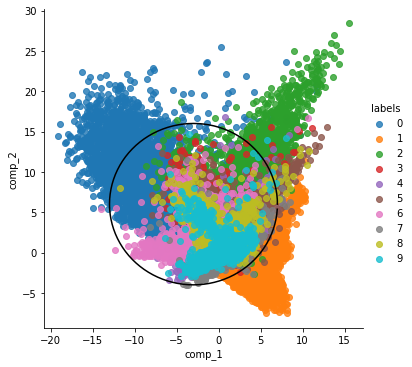

In [71]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [10 * np.cos(2 * np.pi / 100 * i) - 3 for i in range(100)]
all_y = [10 * np.sin(2 * np.pi / 100 * i) + 6 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

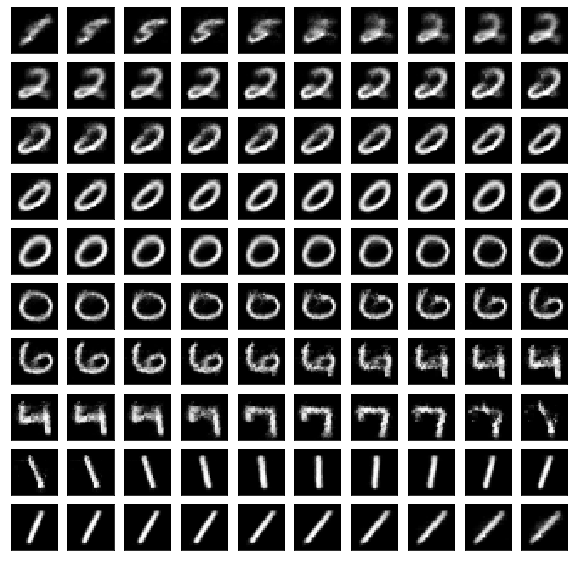

In [72]:
# moving along a circle:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 10 * np.cos(2 * np.pi / 100 * i) - 3
    y = 10 * np.sin(2 * np.pi / 100 * i) + 6
    
    pt = np.array([[x, y]])
    _ = show(decoded.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.2 Moving along an ellipse

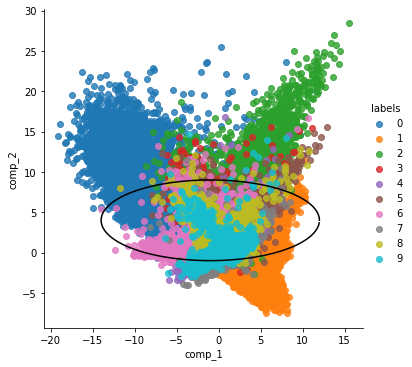

In [66]:
_ = sns.lmplot("comp_1", "comp_2", hue="labels", data=proj, fit_reg=False)
all_x = [13 * np.cos(2 * np.pi / 100 * i) - 1 for i in range(100)]
all_y = [5 * np.sin(2 * np.pi / 100 * i) + 4 for i in range(100)]
_ = plt.plot(all_x, all_y, 'black')

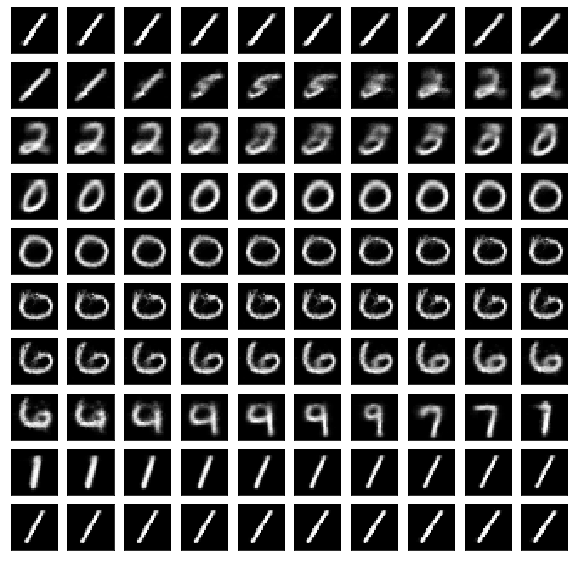

In [67]:
# moving along a elipse:
_ = plt.figure(figsize=(10, 10))

for i in range(100):
    _ = plt.subplot(10, 10, i+1)
    
    x = 13 * np.cos(2 * np.pi / 100 * i) - 1
    y = 5 * np.sin(2 * np.pi / 100 * i) + 4
    
    pt = np.array([[x, y]])
    _ = show(decoded.predict(pt).reshape((28, 28)))
    _ = plt.xticks([])
    _ = plt.yticks([])

### 5.5.3 Moving along a grid

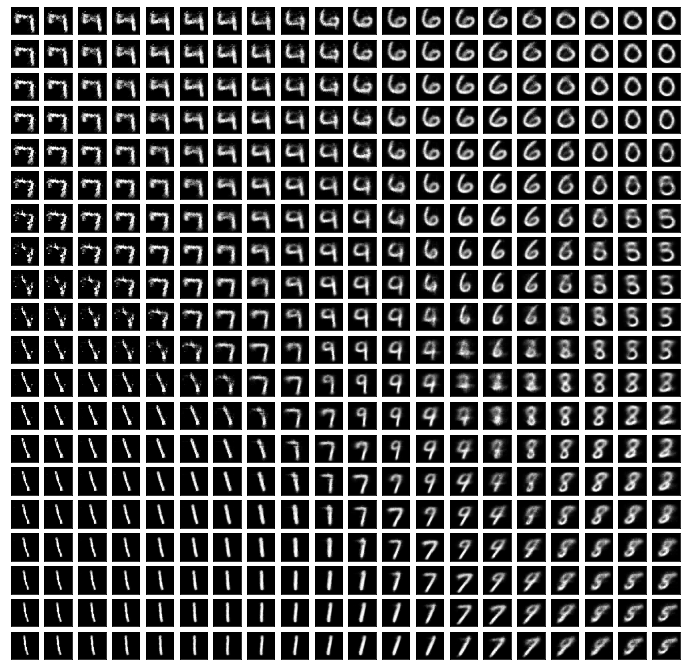

In [68]:
# moving along a elipse:
_ = plt.figure(figsize=(12, 12))

for i in range(20):
    for j in range(20):
        
        _ = plt.subplot(20, 20, i * 20 + j + 1)
        
        pt = np.array([[ -6 + 10 * i / 19, -6 + 10 * j / 19]])
        _ = show(decoded.predict(pt).reshape((28, 28)))
        _ = plt.xticks([])
        _ = plt.yticks([])